# Autoregressive processes
* Theory
* Practical
    * Prepare your data for Autoregression - trend, variance, seasonality
    * Build a lag / series of lags
    * Make a prediction based on this lag/lags
    * Reconstruct - Undo stationarity on the prediction
    * Check autocorrelation
* Further reading:
    * Seasonal decomposition
    * Statsmodels AR model
    * Facebook Prophet


---

In [1]:
import numpy as np

## Theory behind AR(p)

An autoregressive process is a stochastic process of the form:

$$
y_t = b + \sum_{j=1}^{P}w_{j}Y_{t-j} + \epsilon_t
$$

where $b$ is the bias, $w_j$ are the weights of the model and $\epsilon$ is some iid (e.g. Gaussian) noise. For the noise it holds that $E(\epsilon_t) = E(\epsilon) = 0$ and $V(\epsilon_t) = V(\epsilon) = \sigma^2$. E.g. expectation and variance are constant and time invariant.


For the case of $P=1$ we can write the process as:

$$
y_t = b + w_1Y_{t-1} + \epsilon_t
$$

This can then be used to make predictions n-steps in the future, by using the prediction at time step t+1 as input to predicting time t+2 etc. [Find out more here](https://en.wikipedia.org/wiki/Autoregressive_model#n-step-ahead_forecasting)








---

### Practical:
* Stationarise the data
* Build a lag (== build X data) on the stationarised data
* Predict
* Undo stationarity on the prediction
* Check autocorrelation

trend, seasonality, and variance in temperature data we can correct for

noise (error term) we cannnot correct for (there is no pattern in the noise)

---

#### Imports

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

#### Load the data

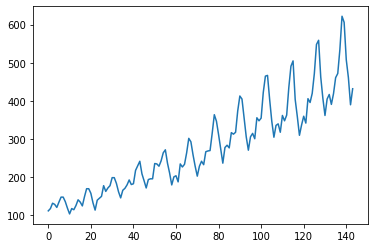

In [3]:
df = sns.load_dataset('flights')
df.passengers.plot()

#### Create a timestamp column

In [4]:
df.columns

Index(['year', 'month', 'passengers'], dtype='object')

In [5]:
df['timestamp'] = df['month'].astype(str) + " " + df['year'].astype(str)

In [6]:
df.set_index('timestamp', inplace=True)

---

### Stationarise the data

---

#### Treat for variance

* Treating for increasing / decreasing variance can be handled with logs / exponents respectively

In [7]:
df['log_passengers'] = np.log(df.passengers)
# standardizes our variance over time

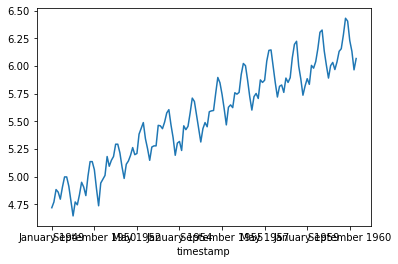

In [8]:
df.log_passengers.plot()

#### Treat for Trend
* How many orders we treat for defines our 'integration'
* first order diffs de-trend linear plots
* second order diffs de-trend polynomial plots
* third + are rarely needed

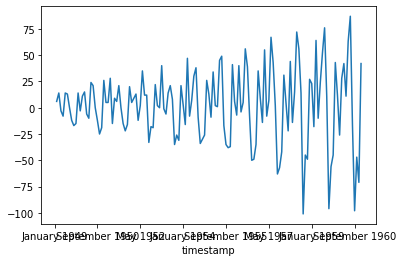

In [9]:
# removing the trend out of the data:
df.passengers.diff().plot() # the relative change
# the change between the current value and the value at the previous timestamp

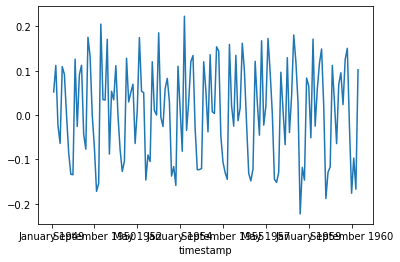

In [10]:
# but there is still the increase in variance in the data
# we need to apply the diff to the log of the passenger dataset
df['diff_log'] = df.log_passengers.diff()
df.diff_log.plot()
# now it is corrected for trend AND variance!

In [11]:
# preprocess the data until you do not violate the assumptions 
# for linear regression anymore!

# the trick is:
# try the models
# if you get a high score but the cross validation is skewed
# then the preprocessing was not sufficient

#### Seasonality
* Use transform or apply to calculate the monthly mean
* Then de-mean each value by its respective mean

In [12]:
# flower sales: spike on 14th february
# sin wave: spike every one rotation around the circle...cos wave to sine wav

In [45]:
# if i do not use transform, then i would have to write a long function to fill all the rows

In [14]:
# passengers fly less during the winter, more during the summer
# regular seasonal pattern

df['monthly_mean'] = df.groupby('month')['diff_log'].transform('mean')
# .mean() gives you the mean of each month
# but what i really wanna do i wanna reduce it by the mean of the month it finds itself in
# .transform('mean') does it!
df.head()

,year,month,passengers,log_passengers,diff_log,monthly_mean
timestamp,,,,,,
January 1949,1949,January,112,4.718499,NaN,0.025154
February 1949,1949,February,118,4.770685,0.052186,-0.011986
March 1949,1949,March,132,4.882802,0.112117,0.140296
April 1949,1949,April,129,4.859812,-0.022990,-0.021200
May 1949,1949,May,121,4.795791,-0.064022,0.007696


In [15]:
df['stationary_passengers'] =  df.diff_log - df.monthly_mean # requires df.monthly_mean to be 144 rows long
df['stationary_passengers'] 
# stationary passengers has had variance, trend and seasonality removed

timestamp
January 1949           NaN
February 1949     0.064172
March 1949       -0.028179
April 1949       -0.001789
May 1949         -0.071718
                    ...   
August 1960      -0.026834
September 1960   -0.041833
October 1960      0.031006
November 1960    -0.033602
December 1960    -0.021655
Name: stationary_passengers, Length: 144, dtype: float64

---

In [ ]:
#  in timeseries: X data has to be historical data of itself
# that s why we have to create more data (by shifting the data) 

# shifting the data through time 

### Build a lag
* An autoregression model is a linear regression model that uses lagged variables as input variables, so we need to identify and define p
* The lag of p will be how far into the future we are predicting!
* We should check out the correlation of each lag to help us decide

In [16]:
YEAR = list(range(1,13))
YEAR

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [17]:
for month in YEAR:
    df[f'{month}_shifted_stationary_data'] = df.stationary_passengers.shift(month)

In [18]:
df.head()

,year,month,passengers,log_passengers,diff_log,monthly_mean,stationary_passengers,1_shifted_stationary_data,2_shifted_stationary_data,3_shifted_stationary_data,4_shifted_stationary_data,5_shifted_stationary_data,6_shifted_stationary_data,7_shifted_stationary_data,8_shifted_stationary_data,9_shifted_stationary_data,10_shifted_stationary_data,11_shifted_stationary_data,12_shifted_stationary_data
timestamp,,,,,,,,,,,,,,,,,,,
January 1949,1949,January,112,4.718499,NaN,0.025154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
February 1949,1949,February,118,4.770685,0.052186,-0.011986,0.064172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
March 1949,1949,March,132,4.882802,0.112117,0.140296,-0.028179,0.064172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
April 1949,1949,April,129,4.859812,-0.022990,-0.021200,-0.001789,-0.028179,0.064172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
May 1949,1949,May,121,4.795791,-0.064022,0.007696,-0.071718,-0.001789,-0.028179,0.064172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
df.isna().sum()

year                           0
month                          0
passengers                     0
log_passengers                 0
diff_log                       1
monthly_mean                   0
stationary_passengers          1
1_shifted_stationary_data      2
2_shifted_stationary_data      3
3_shifted_stationary_data      4
4_shifted_stationary_data      5
5_shifted_stationary_data      6
6_shifted_stationary_data      7
7_shifted_stationary_data      8
8_shifted_stationary_data      9
9_shifted_stationary_data     10
10_shifted_stationary_data    11
11_shifted_stationary_data    12
12_shifted_stationary_data    13
dtype: int64

In [20]:
df.fillna(method='bfill', inplace=True) # fill missing values

In [21]:
df.isna().sum()

year                          0
month                         0
passengers                    0
log_passengers                0
diff_log                      0
monthly_mean                  0
stationary_passengers         0
1_shifted_stationary_data     0
2_shifted_stationary_data     0
3_shifted_stationary_data     0
4_shifted_stationary_data     0
5_shifted_stationary_data     0
6_shifted_stationary_data     0
7_shifted_stationary_data     0
8_shifted_stationary_data     0
9_shifted_stationary_data     0
10_shifted_stationary_data    0
11_shifted_stationary_data    0
12_shifted_stationary_data    0
dtype: int64

#### Lets visualise the effectiveness of each lag with a heatmap, and pick a feature

In [27]:
[x for x in df.columns if ('stationary') in x]

['stationary_passengers',
 '1_shifted_stationary_data',
 '2_shifted_stationary_data',
 '3_shifted_stationary_data',
 '4_shifted_stationary_data',
 '5_shifted_stationary_data',
 '6_shifted_stationary_data',
 '7_shifted_stationary_data',
 '8_shifted_stationary_data',
 '9_shifted_stationary_data',
 '10_shifted_stationary_data',
 '11_shifted_stationary_data',
 '12_shifted_stationary_data']

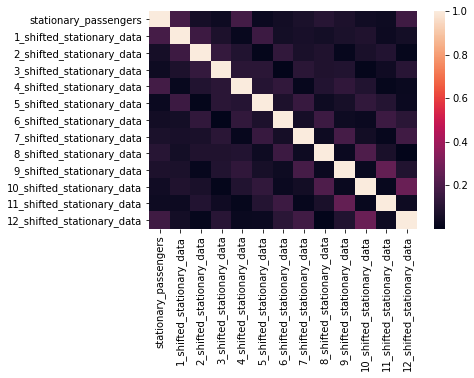

In [28]:
sns.heatmap(df[[x for x in df.columns if ('stationary') in x]].corr().abs()) # absolute values, we do not care about negative corr relationships

In [30]:
# 1,4 and 12 appear to be useful (bright color) showing strong correlated lags

---

## Predict

### Train-Test Split:
- Last 20 months -> Testing
- All months except the Last 20 -> Training

In [31]:
df.columns

Index(['year', 'month', 'passengers', 'log_passengers', 'diff_log',
       'monthly_mean', 'stationary_passengers', '1_shifted_stationary_data',
       '2_shifted_stationary_data', '3_shifted_stationary_data',
       '4_shifted_stationary_data', '5_shifted_stationary_data',
       '6_shifted_stationary_data', '7_shifted_stationary_data',
       '8_shifted_stationary_data', '9_shifted_stationary_data',
       '10_shifted_stationary_data', '11_shifted_stationary_data',
       '12_shifted_stationary_data'],
      dtype='object')

In [32]:
features = ['1_shifted_stationary_data', '4_shifted_stationary_data', '12_shifted_stationary_data']

In [34]:
# no train_test_split(X, y) because it is random
# and in time series data the sequence is very important!


In [35]:
Xtrain = df[:20][features]
ytrain = df[:20]['stationary_passengers'] # would be stationary climate data for me!

Xtest = df[20:][features]
ytest = df[20:]['stationary_passengers']

In [36]:
from sklearn.linear_model import LinearRegression

In [37]:
m = LinearRegression()
m.fit(Xtrain, ytrain)
# m.score(Xtrain, ytrain) we might violate the assumptions

0.07165269216837022

In [40]:
ypred = m.predict(Xtest)

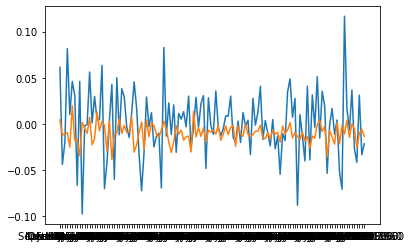

In [44]:
plt.plot(ytest.index, ytest)
plt.plot(ytest.index, ypred)
# predicting the stationary passenger data here!!!
# it is NOT A PASSENGER DATA PREDICTION - BUT A TRANSFORMED PASSENGER PREDICTION
# BUT WE ARE EXPEXTING THE LINES TO BE CLOSE!!!

---

## Reconstruct - Very important!
* Exercise for the you all
* We aren't predicting stationary data, but actual data
* So we have to undo what we just did

In [ ]:
# you need to unstationarize ypred!
# take ypred and pass it to the inverse transform for all of the steps

# 1 ....
# 2. take a baseline .... instead of diff
# 3. exponent function instead of log 

---

### Check auto-correlation and partial auto-correlation
* PACF removes the relationship of intervening time-steps
* ACF does not
* Confidence intervals (at 95%) are drawn as a cone. Values **outside** of this code are very likely a correlation and **not** a statistical fluke

In [24]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

ACF Plot Explained: https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/


---

## Checklist!! Apply this to your climate data:
* Stationarise the data
* Build a lag / series of lags
* Make a prediction based on this lag/lags
* Reconstruct - Undo stationarity on the prediction
* Check autocorrelation

---

### Further reading:
* Seasonal decomposition
* Statsmodels AR model
* Facebook Prophet
* non-manual - dickey-fuller, seasonal adjustment

#### Seasonal Decomposition

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose
sdc = seasonal_decompose(Xtrain, period=12, model='additive')
sdc.plot()
None

NameError: name 'Xtrain' is not defined

#### Statsmodel AR

In [ ]:
from statsmodels.tsa.ar_model import AR

ar = AR(df['passengers'])
ar_fitted = ar.fit()
ar_fitted.predict(end='1968')
ypred = ar_fitted.predict(end='1968')
plt.plot(ypred)
plt.plot(df['passengers'])
sns.heatmap(pd.DataFrame(ar_fitted.params).iloc[1:])

#### FB Prophet 

- https://facebook.github.io/prophet/docs/quick_start.html#python-api

#### Non-manual

- https://en.wikipedia.org/wiki/Seasonal_adjustment
- https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html